#### Aug. 13, 2018 12pm

In [1]:
import numpy   as np
import pandas  as pd

import pickle
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


---

#### Function Definitions

In [2]:
def time_Now():
    import datetime
    import pytz
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return (pst_now)

In [3]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label',  fontsize=14)
    plt.xlabel('Predicted label',  fontsize=14)

In [4]:
def plot_model_ROC(model, X_df, y_true, figTitle=None, printMetrics=False, figName=None):
    '''
        Function will plot the Model's ROC curve with several options:
        - alter the fig TITLE
        - APPEND model metrics to the figure
        - SAVE figure as a *.png and a*.pdf file
        
        Function will execute with only 3 of the 6 parameters
        - sklearn model that can give a predict_proba
        - X_df to apply the predict_proba
        - y_true the true values to compute TPR and FPR (T/F positive rates)
    '''
    
    pred = model.predict(X_df)
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);
    
    if figTitle:
        plt.title(figTitle)
    else:
        plt.title(str(model))
        
    if printMetrics:
        plt.text(.6, .15, "Accuracy score: {0:.4f}".format( accuracy_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .2, "Precision score: {0:.4f}".format( precision_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .25, "Recall score: {0:.4f}".format( recall_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .3, "F1 score: {0:.4f}".format( f1_score(y_true, pred) ), fontsize=14);

    if figName:
        print("saving..." + figName)
        plt.gcf()
        plt.savefig(figName + '.png')
        plt.savefig(figName + '.pdf')

In [5]:
def show_most_informative_features(vectorizer, clf, n=20):
    
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [6]:
def topWords(clf_model_nb, vectorFts, numFtrs=50):

    
    # Empirical log probability of features x_i, given a class y; P(x_i|y).

    ftr_logProb = clf_model_nb.feature_log_prob_
    ftr_logProb.shape

    # Smoothed empirical log probability for each class.
    class_logProb = clf_model_nb.class_log_prior_


    posterior_ratios = (ftr_logProb[1,:] - ftr_logProb[0,:] + class_logProb[1] - class_logProb[0])

    inds = np.argsort(posterior_ratios)[-1:-200:-1]

    # posterior_ratios[inds]

    print(np.array(vectorFts)[inds])

---
### Modified: 

In [7]:
print("Last modified on: ", time_Now())

Last modified on:  2018-08-13 12:48:04.175285-07:00


---

### Large Pickled Dataset



In [8]:
%%time
df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 956 ms, sys: 688 ms, total: 1.64 s
Wall time: 5.11 s


In [9]:
%%time
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

CPU times: user 100 ms, sys: 24 ms, total: 124 ms
Wall time: 124 ms


In [10]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923002 entries, 0 to 923001
Data columns (total 17 columns):
business_id    923002 non-null object
name           923002 non-null object
review_id      923002 non-null object
stars          923002 non-null int64
date           923002 non-null datetime64[ns]
text           923002 non-null object
useful         923002 non-null int64
funny          923002 non-null int64
cool           923002 non-null int64
city           923002 non-null object
state          923002 non-null object
Thai           923002 non-null float64
Italian        923002 non-null float64
Indian         923002 non-null float64
Chinese        923002 non-null float64
Mexican        923002 non-null float64
Text_length    923002 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5), object(6)
memory usage: 119.7+ MB


In [11]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 15.9 s, sys: 0 ns, total: 15.9 s
Wall time: 15.9 s


In [12]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 652 ms, sys: 0 ns, total: 652 ms
Wall time: 653 ms


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [14]:
print( X_train.shape, X_test.shape)

(646101, 17) (276901, 17)


---

### Manipulate data sets

In [143]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])
# 189
stopWords.extend(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg', 'aaaaaaah'])
stopWords.extend(['aaaaaaamazing', 'aaaaaaand', 'aaaaaamazing', 'aaaaahhhh', 'aaaaahhhhhhmazing', 'aaaaahhhhmaaazeballs', 'aaaaamazing', 'aaaaand'])
stopWords.extend(['aaaack', 'aaaamazing', 'aaaammmazziiigggg', 'aaaand', 'aaaarrgh', 'aaah', 'aaahh'])
stopWords.extend(['aaahhhh', 'aaahhhhh', 'aaahhhhmmmaaazzziiiinnnnggg'])
stopWords.extend(['aaammaziiiing', 'aaand', 'aab', 'aaboud', 'aac', 'aachi', 'aadd', 'aaggh', 'aagh', 'aah', 'aahan', 'aahc', 'aahhh'])
stopWords.extend(['aahhhh', 'aahhhhhh', 'aahhhhhhmazing', 'aahhhhhmazing', 'aahhhhmazing', 'aahing', 'aahran'])
# 234
stopWords.extend(['aaaaaaaaaa', 'aaaaaaaaaaaaaand', 'aaaaaaaaaaaaaauthentic', 'aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww', 'aaaaaaaaaaack', 'aaaaaaaaaaah', 'aaaaaaaaaand', 'aaaaaaaaargh', 'aaaaaaaack', 'aaaaaaaahhhhhhhhh', 'aaaaaaaamazing', 'aaaaaaaand', 'aaaaaaall', 'aaaaaaamaaaaazing', 'aaaaaaammmmazing', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhmazing', 'aaaaaand', 'aaaaaannnddd', 'aaaaaannnndddd', 'aaaaagh', 'aaaaah', 'aaaaahhhhmazing', 'aaaaamaaazing', 'aaaaammmaazzzinnngg', 'aaaaarrrggghh', 'aaaaawful', 'aaaaay', 'aaaagh', 'aaaah', 'aaaahh', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaahmazzzing', 'aaaajúa', 'aaaall', 'aaaalllllllll', 'aaaallright', 'aaaammaaazzinnnggg', 'aaaammazzing', 'aaaammmaaaaazzzziiiinnnngggg', 'aaaammmaaazing', 'aaaammmmmmazing', 'aaaamzing', 'aaaandd', 'aaaanddd', 'aaaannnd', 'aaaannnnd', 'aaaanyway', 'aaaawesoooome', 'aaaawwwesome', 'aaaawwwww', 'aaagggrrrrrrrhhhhh', 'aaahahaa', 'aaahhh', 'aaahhhhhhh', 'aaahhhs', 'aaahing', 'aaahmaaaazing', 'aaahmazing', 'aaahs', 'aaaiiiiight', 'aaall', 'aaallll', 'aaalways', 'aaamaazing', 'aaamazing', 'aaammaaazzziinnnngggg', 'aaammazing', 'aaammmazing', 'aaammmazinggggg', 'aaammmmaaazzziinnggg', 'aaannd', 'aaanndd', 'aaannndd', 'aaannnnd', 'aaanyway', 'aaare', 'aaawwee', 'aaawww', 'aaawwwwsome', 'aaay', 'aacross', 'aadbcc', 'aadorbsssssss', 'aagain', 'aahaan', 'aahed', 'aahh', 'aahs', 'aaid', 'aaiight', 'aaiiight', 'aaim', 'aaka', 'aaked', 'aaliyah', 'aall'])
stopWords.extend(['aaaaaaaaaaaaahhhhhhh', 'aaaaaaaaaah', 'aaaaaaaahhhhmazing', 'aaaaaaaawesooooooooooooome', 'aaaaaaggghhh', 'aaaaaah', 'aaaaaawesome', 'aaaaahhh', 'aaaaahhhhhh', 'aaaahhhhhhs', 'aaaajua', 'aaaalmost', 'aaaamazzzzing', 'aaaammaaazzziiingggg', 'aaaarreeeee', 'aaagh', 'aaahed', 'aaahhhmaaaazing', 'aaahhhmazing', 'aaammaazzing', 'aaarghhh', 'aahaha', 'aahhhhhaaaahhhhh'])
# 357

In [144]:
vectorizer = CountVectorizer(stop_words=stopWords, strip_accents = 'ascii' )

#### Vectorize Review Text

In [36]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

X_train_term.shape

ftrs = vectorizer.get_feature_names()
ftrs

len(vectorizer.get_stop_words())

CPU times: user 47.2 s, sys: 648 ms, total: 47.9 s
Wall time: 47.8 s


---

#### Mutlinomial NB - Train

In [40]:
%%time
M_NB_model = MultinomialNB()

%%time
M_NB_model.fit(X_train_term, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.6 µs


---

#### Multinomial NB - Test

In [42]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

X_test_term.shape

%%time
pred = M_NB_model.predict(X_test_term)

CPU times: user 21.5 s, sys: 100 ms, total: 21.6 s
Wall time: 21.6 s


In [45]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.90      0.91      0.90    220388
        1.0       0.63      0.62      0.62     56513

avg / total       0.85      0.85      0.85    276901



In [46]:
accuracy_score(y_test, pred)

0.8475809043665425

In [47]:
precision_score(y_test, pred)

0.6284196165721261

In [48]:
recall_score(y_test, pred)

0.6194680869888344

In [49]:
f1_score(y_test, pred)

0.6239117455734666

Confusion matrix, without normalization


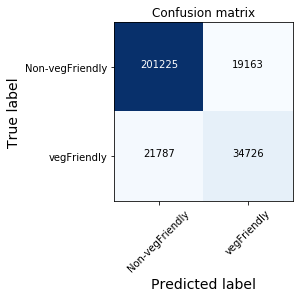

In [31]:
lbls = ['Non-vegFriendly', 'vegFriendly']
cm = confusion_matrix(y_test, pred)

plot_confusion_matrix(cm,lbls)

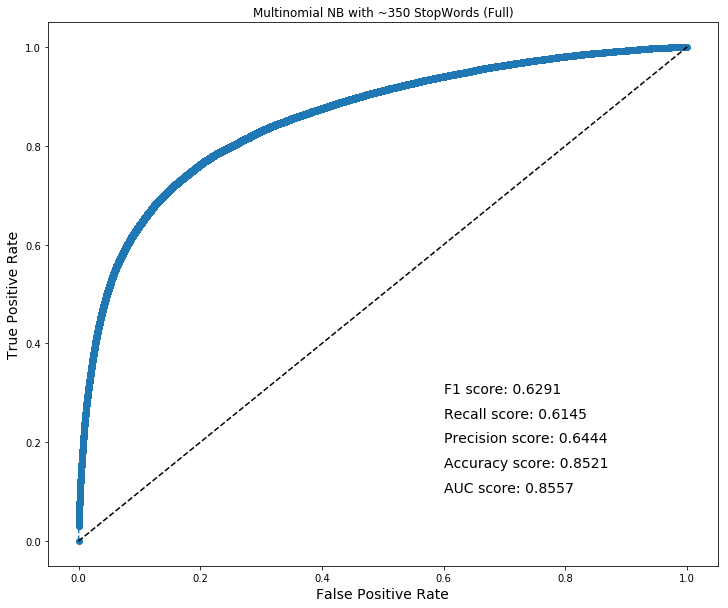

In [32]:
%%time
fTitle = 'Multinomial NB with ~350 StopWords (Full)'
mMetrics = True
fName = 'MNB_357StWds_full_countV'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)#, fName)

CPU times: user 648 ms, sys: 76 ms, total: 724 ms
Wall time: 722 ms


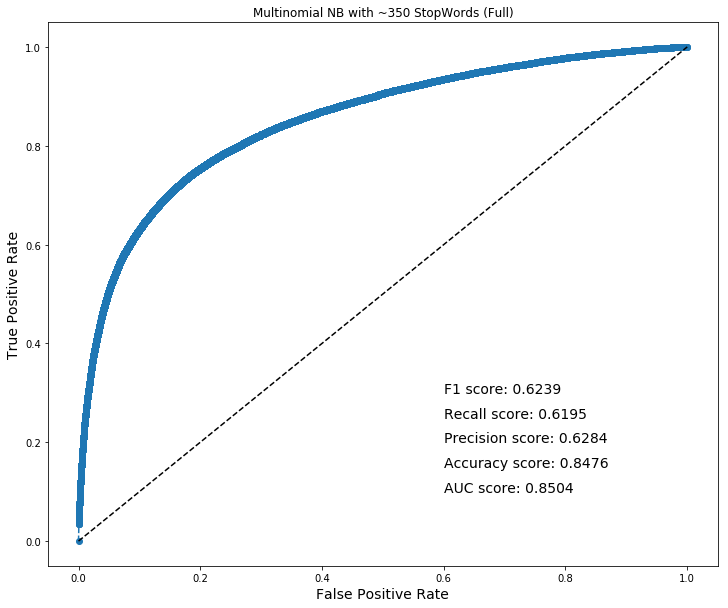

In [50]:
%%time
# NEW FIT cvt()
fTitle = 'Multinomial NB with ~350 StopWords (Full)'
mMetrics = True
fName = 'MNB_357StWds_full_countV'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)#, fName)

---

### Log odds of priors

In [33]:
show_most_informative_features(vectorizer, M_NB_model, 20)

	-15.7114	aaaaaaaaaaaand 		-4.0060	food           
	-15.7114	aaaaaaahhhhhh  		-4.6553	great          
	-15.7114	aaaamaaazing   		-4.9458	service        
	-15.7114	aaaayway       		-5.1160	one            
	-15.7114	aaammmaziinng  		-5.1255	time           
	-15.7114	aaammmmaaazzziinnngg		-5.1506	back           
	-15.7114	aakowa         		-5.1926	go             
	-15.7114	aalad          		-5.2409	get            
	-15.7114	aalll          		-5.2438	chicken        
	-15.7114	aalmon         		-5.2991	would          
	-15.7114	aalo           		-5.3274	restaurant     
	-15.7114	aalways        		-5.3395	also           
	-15.7114	aalyssa        		-5.3447	delicious      
	-15.7114	aamaaazing     		-5.4260	love           
	-15.7114	aamaazingly    		-5.4355	menu           
	-15.7114	aamazing       		-5.4379	vegan          
	-15.7114	aamco          		-5.4584	try            
	-15.7114	aammaazzing    		-5.5425	order          
	-15.7114	aamsotto       		-5.6005	got            
	-15.7114	aamzing        	

In [51]:
# cvt()
show_most_informative_features(vectorizer, M_NB_model, 20)

	-16.3774	aaaaa          		-2.9090	the            
	-16.3774	aaaaaa         		-3.2796	and            
	-16.3774	aaaaaaaaaa     		-3.7851	to             
	-16.3774	aaaaaaaaaaaaaand		-3.9267	was            
	-16.3774	aaaaaaaaaaaaaauthentic		-4.0493	it             
	-16.3774	aaaaaaaaaaaaahhhhhhh		-4.1637	of             
	-16.3774	aaaaaaaaaaaand 		-4.2425	is             
	-16.3774	aaaaaaaaaaack  		-4.4094	for            
	-16.3774	aaaaaaaaaaah   		-4.5333	in             
	-16.3774	aaaaaaaaaand   		-4.6720	food           
	-16.3774	aaaaaaaaargh   		-4.6879	we             
	-16.3774	aaaaaaaack     		-4.6883	with           
	-16.3774	aaaaaaaahhhhhhhhh		-4.6987	my             
	-16.3774	aaaaaaahhhhhh  		-4.7053	this           
	-16.3774	aaaaaaall      		-4.7145	that           
	-16.3774	aaaaaaamaaaaazing		-4.7338	but            
	-16.3774	aaaaaaand      		-4.8236	you            
	-16.3774	aaaaaah        		-4.8683	they           
	-16.3774	aaaaaahhhh     		-4.9948	on             
	-16.3774	aaaa

---
### Ratio of posteriors for both classes

In [34]:
topWords(M_NB_model, ftrs, 50)

['injera' 'tsoynami' 'vegenation' 'nami' 'tsoynamis' 'vegeway' 'lalibela'
 'gomen' 'grabbagreen' 'wac' 'soynami' 'doro' 'brimstone' 'tibs'
 'lunasagna' 'capastrami' 'chopt' 'brizza' 'tfk' 'mijana' 'eatt' 'pastoli'
 'buraka' 'misir' 'hemp' 'wellness' 'ethiopian' 'dotty' 'choolaah'
 'alicha' 'apteka' 'grabba' 'olivier' 'tlt' 'zizi' 'chakra' 'fuegos'
 'jovany' 'lgbtq' 'taytu' 'tsom' 'yayo' 'chima' 'yinzburgh' 'ycs'
 'merkato' 'dobra' 'misoya' 'quesas' 'wheatgrass' 'thailicious' 'hussong'
 'rawco' 'tikil' 'soynamis' 'fern' 'berbere' 'ikes' 'fosolia' 'abay'
 'mvpita' 'rvc' 'pitza' 'veganaise' 'chopshop' 'zenith' 'turban'
 'cinnaholic' 'violette' 'ladonia' 'capistrami' 'ipho' 'graz' 'panevino'
 'yc' 'jungles' 'teff' 'mestizo' 'arieanna' 'dumplinghaus' 'pitaya'
 'tofurky' 'kinoko' 'kitfo' 'sega' 'ruchi' 'rani' 'zoma' 'chikn' 'sonio'
 'nush' 'everly' 'shawerma' 'fatoosh' 'quiessence' 'acai' 'treehouse'
 'ganoosh' 'sambusas' 'ayib' 'dougan' 'naji' 'zizis' 'rodizio' 'sprinly'
 'greene' 'namastay

In [54]:
# cvt()
topWords(M_NB_model, ftrs, 50)

['injera' 'tsoynami' 'vegenation' 'nami' 'tsoynamis' 'vegeway' 'lalibela'
 'gomen' 'grabbagreen' 'wac' 'soynami' 'doro' 'brimstone' 'tibs'
 'lunasagna' 'capastrami' 'brizza' 'chopt' 'tfk' 'mijana' 'eatt' 'pastoli'
 'buraka' 'misir' 'hemp' 'wellness' 'ethiopian' 'dotty' 'choolaah'
 'alicha' 'apteka' 'grabba' 'olivier' 'tlt' 'zizi' 'chakra' 'fuegos'
 'jovany' 'lgbtq' 'taytu' 'yayo' 'tsom' 'chima' 'yinzburgh' 'ycs'
 'merkato' 'dobra' 'misoya' 'quesas' 'wheatgrass' 'thailicious' 'hussong'
 'rawco' 'tikil' 'soynamis' 'fern' 'berbere' 'ikes' 'fosolia' 'abay' 'rvc'
 'mvpita' 'pitza' 'chopshop' 'veganaise' 'zenith' 'turban' 'cinnaholic'
 'violette' 'ipho' 'graz' 'ladonia' 'capistrami' 'panevino' 'yc' 'jungles'
 'teff' 'mestizo' 'arieanna' 'dumplinghaus' 'pitaya' 'kitfo' 'kinoko'
 'tofurky' 'sega' 'ruchi' 'rani' 'nush' 'chikn' 'sonio' 'zoma' 'everly'
 'fatoosh' 'shawerma' 'quiessence' 'acai' 'treehouse' 'namastay'
 'sambusas' 'sprinly' 'zizis' 'rodizio' 'ayib' 'dougan' 'naji' 'ganoosh'
 'greene

In [55]:
X_train_term

<646101x141728 sparse matrix of type '<class 'numpy.int64'>'
	with 43192597 stored elements in Compressed Sparse Row format>

In [82]:
%%time
empty_row = []

for i in range(646101):
    empty_row.append(len(X_train_term.getrow(i).indices))

CPU times: user 34.3 s, sys: 720 ms, total: 35 s
Wall time: 33.8 s


In [83]:
len(empty_row)

646101

In [84]:
import matplotlib.pyplot as plt

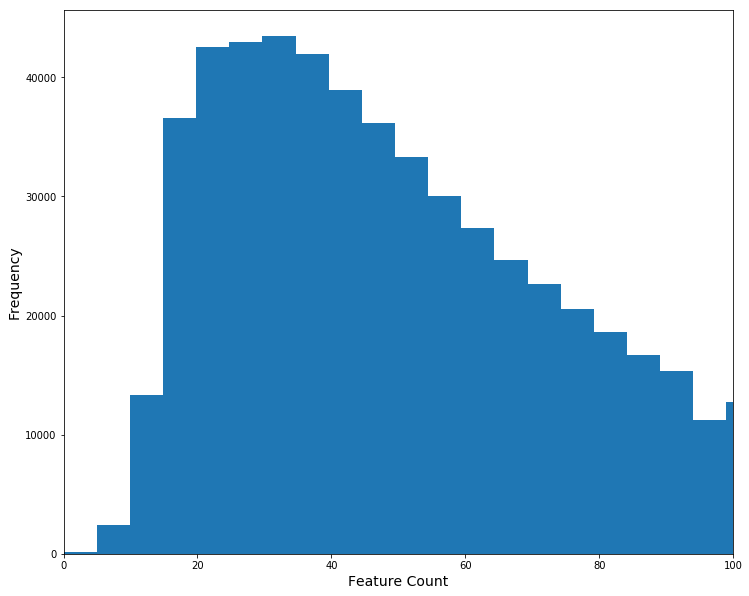

In [95]:
plt.figure(figsize=(12,10))
plt.hist(empty_row, bins = 100)
plt.xlim((0, 100))
plt.xlabel('Feature Count',  fontsize=14)
plt.ylabel('Frequency',  fontsize=14);

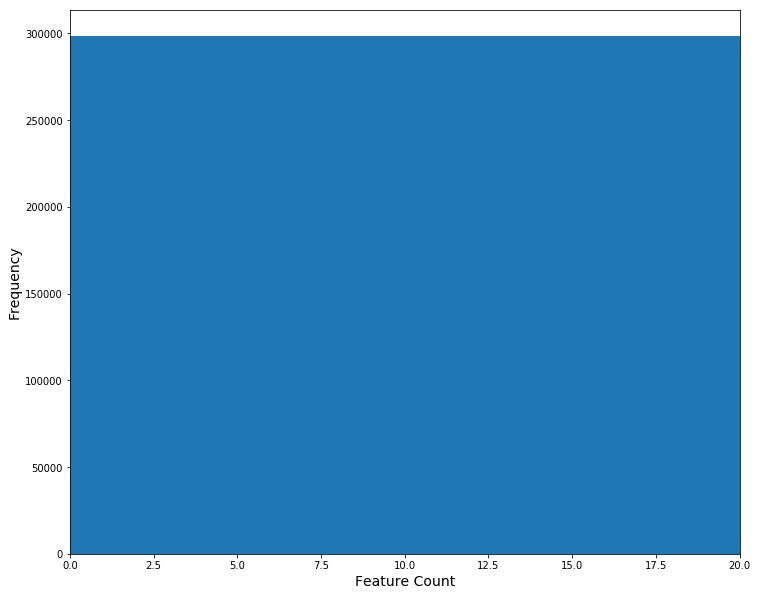

In [97]:
plt.figure(figsize=(12,10))
plt.hist(empty_row)
plt.xlim((0, 20))
plt.xlabel('Feature Count',  fontsize=14)
plt.ylabel('Frequency',  fontsize=14);

In [98]:
eRow = np.array(empty_row)

In [113]:
x_small = X_train_term[eRow < 16]

In [114]:
x_small

<22087x141728 sparse matrix of type '<class 'numpy.int64'>'
	with 281954 stored elements in Compressed Sparse Row format>

In [109]:
x_small[0,:]

<1x141728 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [117]:
np.unique([0,1,1,1,2,2], return_counts=True)

(array([0, 1, 2]), array([1, 3, 2]))

In [118]:
np.unique(eRow, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [120]:
X_train[ eRow == 464 ]

,business_id,name,review_id,stars,date,text,useful,funny,cool,city,state,Thai,Italian,Indian,Chinese,Mexican,Text_length
262278,cgZOP1ZUBOZmEQMSJ53oiQ,Chef Marc's Trattoria,ZY2cOzgwToolJnCawVoguA,4,2016-08-07,Items Served:\nPizza Focaccia and Warm Semolin...,6,2,3,Las Vegas,NV,0.0,1.0,0.0,0.0,0.0,4998
240987,cyzOijFJ82cae6qH6L8vuw,Arawan Thai Bistro and Dessert,PAJ26j9QbDjmYbbPxdsaGw,4,2017-04-04,Items Selected:\nThai Iced Tea\nCrispy Wontons...,5,2,4,Las Vegas,NV,1.0,0.0,0.0,0.0,0.0,4963
893766,ZpMoI5EECS6Rm7KigN1gPg,Jasmine,s4N7NTxOYXJ8yMPQ_E-bUQ,4,2016-02-17,In a city blessed by one of the most underrega...,13,10,9,Las Vegas,NV,0.0,0.0,0.0,1.0,0.0,4804


In [126]:
X_train[ eRow == 464 ].loc[240987,'text']

'Items Selected:\nThai Iced Tea\nCrispy Wontons\nRed Curry Fish Cake\nAhi Tuna Larb\nArawan Pad Thai\nSquid-ink Drunken Noodles\nDuck Palow\nSweet Sensation\nEarthquake\n\nOpen now for just under two years, the choice to join a plaza already featuring world famous Lotus of Siam and Komol Restaurant originally an odd choice that had many labeling them \'that new Thai place near Lotus,\' Arawan Thai Bistro and Dessert has defied the odds by etching out their own unique style of Thai cuisine that is quite unlike any other in Las Vegas, the duo of Chefs Jui and Gail creating some truly beautiful dishes with a focus on quality ingredients that do not compromise authenticity.\n\nTechnically located in "Commercial Center," though if any local is asked the answer to "where is it?" almost always revolves around its Beard Award Winning competition, Arawan Thai Bistro and Dessert joins most of the Las Vegas off-Strip ethnic options in being largely understated in its outward appearance, a noon ar

In [127]:
X_train[ eRow < 4 ]

,business_id,name,review_id,stars,date,text,useful,funny,cool,city,state,Thai,Italian,Indian,Chinese,Mexican,Text_length
23699,AtD6B83S4Mbmq0t7iDnUVA,Veggie House,KFdonDTlEitI30EPZquRvQ,5,2015-03-25,yummmmmmmm,0,0,0,Las Vegas,NV,0.0,0.0,0.0,1.0,0.0,10
90889,aKiE0aZ6vGyOlH-uVOHONw,The Y Eatery,YrdpDZQ777IIO7eH6FrpCw,3,2015-09-04,味道比较普通，但可以解决一顿午饭也是不错的了。,0,0,0,Champaign,IL,1.0,0.0,0.0,0.0,0.0,23
562993,kG0N5urz2lkPEBDPjqFR3w,Maharani Indian Cuisine,sRaWam61vvurLgc13HRJ1g,2,2015-07-04,Salty food!,1,0,1,Charlotte,NC,0.0,0.0,1.0,0.0,0.0,11
186478,bWucOPNoIjd8ECdiDyVq9Q,Singing Pandas Asian Restaurant & Bar,t_uJ4bBN-HIGp-gYyT7ibg,5,2016-08-17,"Great meal, great entertainment!",0,0,0,Chandler,AZ,0.0,0.0,0.0,1.0,0.0,32
649221,rYPpbhnucRdLmpmcjUqoFA,El Bigo Taco,NZqJOmXNaUt7mQ5qKbLLgA,5,2017-04-13,:),0,0,0,Mesa,AZ,0.0,0.0,0.0,0.0,1.0,2
150611,7MeMGh0SUlF-GuTyruwtcw,Mellow Mushroom,5lE5v7nTd3nABDxD3g6OYA,4,2012-03-17,great bartender,1,0,1,Phoenix,AZ,0.0,0.0,0.0,0.0,0.0,15
468566,k34J0L6xAnknbv40WGvpcg,Pizza Hut,WBP5k_cojfOof7HsDwGJfw,2,2011-12-03,ok,0,0,1,Goodyear,AZ,0.0,1.0,0.0,0.0,0.0,2
617748,mpG1R1ktTI3x1twNBsGvXQ,Blue Ginger Asian Bistro,XTjQvPiXiLSkYXWGrH_taQ,5,2015-07-05,v,0,0,0,Parma,OH,0.0,0.0,0.0,1.0,0.0,1
631535,sS__otwzn0INyR_5Dimfdg,Asadero Toro,akUzIQmP7KCNSKh508VspA,4,2013-03-18,Very good food!!!!!,0,0,0,Phoenix,AZ,0.0,0.0,0.0,0.0,1.0,19
576,7S5iOI5Xb9cTUQLmBwCeXw,The Skinny Italian Kitchen,-RoP7U4pcjXkal_SS2tjKQ,5,2012-10-11,Good stuff.,1,1,1,Phoenix,AZ,0.0,1.0,0.0,0.0,0.0,11


In [131]:
row_Index = X_train[ eRow < 16 ].index

X_train.shape

new_X_train = X_train.drop(row_Index)

new_y_train = y_train.drop(row_Index)

new_X_train.shape

%%time
new_X_train_term  = vectorizer.fit_transform(new_X_train['text'])

new_X_train_term.shape

ftrs = vectorizer.get_feature_names()
ftrs

len(vectorizer.get_stop_words())

%%time
M_NB_model = MultinomialNB()

%%time
M_NB_model.fit(new_X_train_term, new_y_train)

%%time
X_test_term = vectorizer.transform(X_test['text'])

X_test_term.shape

%%time
pred = M_NB_model.predict(X_test_term)

lbls = ['Non-vegFriendly', 'vegFriendly']
cm = confusion_matrix(y_test, pred)

plot_confusion_matrix(cm,lbls)

CPU times: user 580 ms, sys: 36 ms, total: 616 ms
Wall time: 616 ms


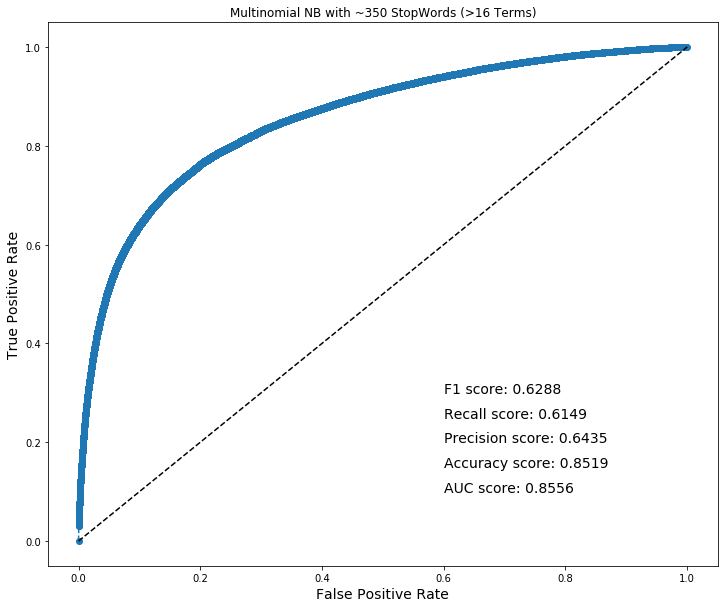

In [173]:
%%time
# NEW FIT low ftr count
fTitle = 'Multinomial NB with ~350 StopWords (>16 Terms)'
mMetrics = True
fName = 'MNB_357StWds_full_countV_16Term'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)#, fName)

Confusion matrix, without normalization
CPU times: user 58.5 s, sys: 388 ms, total: 58.9 s
Wall time: 58.8 s


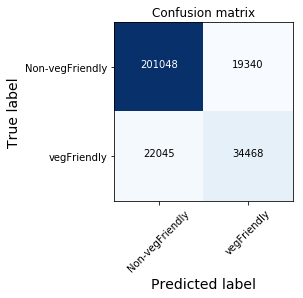

In [174]:
%%time

row_Index = X_train[ eRow < 46 ].index


new_X_train = X_train.drop(row_Index)
new_y_train = y_train.drop(row_Index)


new_X_train_term  = vectorizer.fit_transform(new_X_train['text'])

ftrs = vectorizer.get_feature_names()

M_NB_model = MultinomialNB()
M_NB_model.fit(new_X_train_term, new_y_train)

X_test_term = vectorizer.transform(X_test['text'])
pred = M_NB_model.predict(X_test_term)

lbls = ['Non-vegFriendly', 'vegFriendly']
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,lbls)

CPU times: user 612 ms, sys: 128 ms, total: 740 ms
Wall time: 602 ms


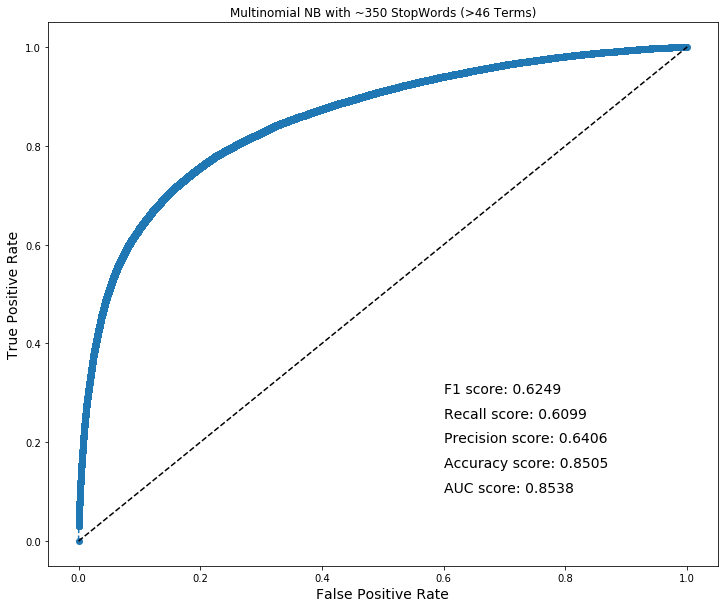

In [175]:
%%time
# NEW FIT low ftr count
fTitle = 'Multinomial NB with ~350 StopWords (>46 Terms)'
mMetrics = True
fName = 'MNB_357StWds_full_countV_46Term'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)#, fName)

In [ ]:
%%time

row_Index = X_train[ eRow < 32 ].index

new_X_train = X_train.drop(row_Index)
new_y_train = y_train.drop(row_Index)


row_Index = X_train[ eRow > 285 ].index
new_X_train.drop(row_Index, inplace=True)
new_y_train.drop(row_Index, inplace=True)

In [177]:
print(new_X_train.shape)

(488221, 17)


Confusion matrix, without normalization


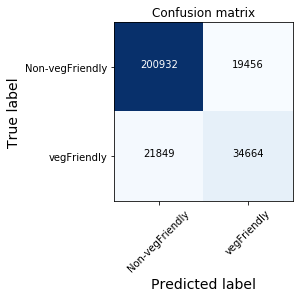

In [178]:
new_X_train_term  = vectorizer.fit_transform(new_X_train['text'])

ftrs = vectorizer.get_feature_names()

M_NB_model = MultinomialNB()
M_NB_model.fit(new_X_train_term, new_y_train)

X_test_term = vectorizer.transform(X_test['text'])
pred = M_NB_model.predict(X_test_term)

lbls = ['Non-vegFriendly', 'vegFriendly']
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,lbls)

CPU times: user 572 ms, sys: 40 ms, total: 612 ms
Wall time: 611 ms


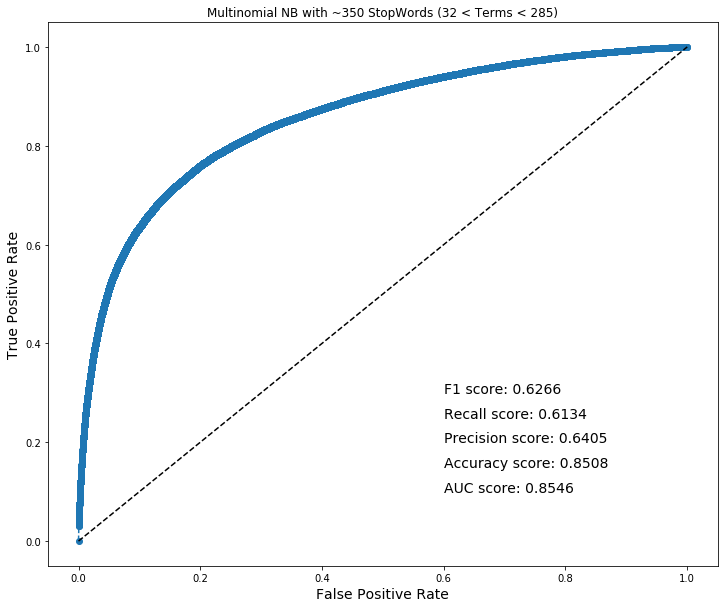

In [179]:
%%time
# NEW FIT low ftr count
fTitle = 'Multinomial NB with ~350 StopWords (32 < Terms < 285)'
mMetrics = True
fName = 'MNB_357StWds_full_countV_gt32_Term_lt285'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)#, fName)

In [74]:
empty_row

[3]